# load modules and 99.25% accuracy CNN for MNIST dataset

In [75]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import PIL
from scipy.special import softmax
import tensorflow as tf
from keras.models import load_model
from keras import backend as K
tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(tf.logging.WARN)

def load_image(image_location):
    x = np.asarray(PIL.Image.open(image_location))
    x = x.reshape(28,28)
    x = x.reshape(1, 28, 28, 1)
    x = x.astype('float32')
    x /= 255
    return x

model = load_model('/Users/zetong/cnn.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# define the loss

5


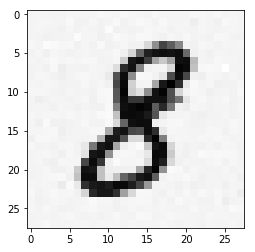

In [64]:
x_new = tf.Variable(np.random.rand(1,28,28,1), dtype=tf.float32)
logits = model(x_new)
target = 7
k = 0
c = 10
x = load_image('/Users/zetong/mnist_png/testing/8/110.png')
nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -k)
train = tf.train.AdamOptimizer(1).minimize(loss, var_list=[x_new])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        #print(sess.run(loss))
        sess.run(train)
        new_img = sess.run(x_new)
        #print(np.argmax(model.predict(new_img)))
    plt.imshow(new_img.reshape((28,28)), cmap='Greys')
    print(np.argmax(model.predict(new_img)))

In [73]:
def targeted_attack(model, original_img, target_label, max_iteration=1000, step_size=0.1, c=1000, k=0):
    x_new = tf.Variable(np.random.rand(1,28,28,1), dtype=tf.float32)
    logits = model(x_new)
    target = target_label
    x = original_img
    nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
    loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -k)
    train = tf.train.AdamOptimizer(step_size).minimize(loss, var_list=[x_new])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(max_iteration):
            #print(sess.run(loss))
            sess.run(train)
            new_img = sess.run(x_new)
            #print(np.argmax(model.predict(new_img)))
        plt.imshow(new_img.reshape((28,28)), cmap='Greys')
        print(np.argmax(model.predict(new_img)))
        return sess.run(x_new)

def untargeted_attack(model, original_img, true_label, max_iteration=1000, step_size=0.1, c=1000, k=0):
    attacks = []
    misclassified_labels = []
    # create adversarial example for each label
    for i in range(10):
        # don't have to create adversarial example for the true label
        if i == true_label:
            continue
        x_new = tf.Variable(np.random.rand(1,28,28,1), dtype=tf.float32)
        logits = model(x_new)
        target = i
        x = original_img
        nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
        loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -k)
        train = tf.train.AdamOptimizer(step_size).minimize(loss, var_list=[x_new])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(max_iteration):
                #print(sess.run(loss))
                sess.run(train)
                new_img = sess.run(x_new)
            prediction = np.argmax(model.predict(new_img))
            if prediction != true_label:
                attacks.append(new_img)
                misclassified_labels.append(prediction)
            sess.close()
    return attacks, misclassified_labels

# putting the adversarial examples and their misclassification labels in subplots
def plot_adversarials(attacks, predicted_labels):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(str(predicted_labels[i-1]))
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    
# attack wrapper function
def attack(model, original_img, max_iteration=1000, step_size=0.1, c=1000, k=0):
    true_label = np.argmax(model.predict(original_img))
    attacks, labels = untargeted_attack(model, x, true_label)
    plot_adversarials(attacks, labels)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x148849048>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x14798d550>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._sess

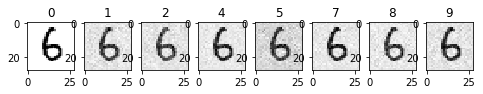

In [76]:
x = load_image('/Users/zetong/mnist_png/testing/6/21.png')
attack(model, x)